# Info

**Project**

Assessment of gap-filling techniques applied to satellite phytoplankton composition products for the Atlantic Ocean

**Credit**

**© Ehsan Mehdipour**, 2025. (ehsan.mehdipour@awi.de)

Alfred Wegener Insitute for Polar and Marine Research, Bremerhaven, Germany

This work is licensed under the **GNU General Public License v3.0 (GPL-3.0)**. 

**Objective**

This script plots a time-series for the original satellite and gap-filled dataset.

**Dataset**

The dataset is accessable through Copernicus Marine Service with the following DOI:
https://doi.org/10.48670/moi-00280 and Dataset ID: cmems_obs-oc_glo_bgc-plankton_my_l3-multi-4km_P1D

# Setup and configuration

## Import modules

In [1]:
# Modules for data analysis
import os
os.environ["OMP_NUM_THREADS"] = "1"
import xarray as xr
import numpy as np
import pandas as pd
import dask

# Modules for data visualisation
import matplotlib.pyplot as plt
plt.rc('text', usetex=True)

# Miscellaneous modules
from tqdm import tqdm

# Manual modules or parameters
from function import *
from params import *

In [2]:
# CSV file detailing the boundries of regions of interest (ROI)

regions = pd.read_csv('data/regions.csv', index_col=0)

# Computations

In [ ]:
## Compute the mean and median of all satellite products for all regions and phytoplankton groups
test_mean = []
dincae_mean = []
dineof_mean = []

test_median = []
dincae_median = []
dineof_median = []

for region in tqdm(range(1,11)):
    
    ## Read development satellite data for coordinates
    ds_dev = xr.open_dataset(os.path.join(params['output_dir'], str(region), f'ds_pft_dev.nc'),chunks='auto')
    ds_dev = ds_dev[params['PFT']]
    time = ds_dev.time
    lat = ds_dev.lat
    lon = ds_dev.lon
    ds_dev = rm_boundry(ds_dev) 

    ## Read full satellite dataset
    ds_test = xr.open_dataset(os.path.join(params['output_dir'], str(region), f'ds_pft.nc'),chunks='auto')
    ds_test = ds_test[params['PFT']]
    ds_test = rm_boundry(ds_test) 
    
    ## read DINCAE gapfilled satellite dataset
    experiment='final'
    ds_dincae = xr.open_dataset(os.path.join(params['output_dir'], str(region), f'DINCAE/{experiment}/ds_reconstructed.nc'),chunks='auto')
    ds_dincae = ds_dincae.assign_coords({'time':time})
    ds_dincae = ds_dincae[params['PFT']]
    # ds_dincae = ds_dincae.sel(time=cloud_date_train.clouded_date.values).compute()
    ds_dincae = rm_boundry(ds_dincae)
    
    ## read DINEOF gapfilled satellite dataset
    experiment='final_6'
    ds_dineof = xr.open_mfdataset(os.path.join(params['output_dir'], str(region), 'DINEOF', str(experiment), 'ds_reconstructed_*.nc'))
    ds_dineof = ds_dineof.rename(
            {'dim003':'time','dim002':'lat','dim001':'lon'}
        ).assign_coords(
            {'time':time, 'lat':lat,'lon':lon}
        )
    ds_dineof = ds_dineof[params['PFT']]
    ds_dineof = rm_boundry(ds_dineof)
    
    ## Compute the mean
    ds_test_mean  = ds_test.mean(dim=['lat','lon'])
    ds_dincae_mean = ds_dincae.mean(dim=['lat','lon'])
    ds_dineof_mean = ds_dineof.mean(dim=['lat','lon'])
    
    ## Compute the median
    ds_test_median  = ds_test.median(dim=['lat','lon'])
    ds_dincae_median = ds_dincae.median(dim=['lat','lon'])
    ds_dineof_median = ds_dineof.median(dim=['lat','lon'])
    
    ## Append all regions into one list
    test_mean.append(ds_test_mean)
    dincae_mean.append(ds_dincae_mean)
    dineof_mean.append(ds_dineof_mean)
    
    test_median.append(ds_test_median)
    dincae_median.append(ds_dincae_median)
    dineof_median.append(ds_dineof_median)

In [ ]:
## Concatenate regions
test_mean = xr.concat(test_mean, dim='region')
dincae_mean = xr.concat(dincae_mean, dim='region')
dineof_mean = xr.concat(dineof_mean, dim='region')

test_median = xr.concat(test_median, dim='region')
dincae_median = xr.concat(dincae_median, dim='region')
dineof_median = xr.concat(dineof_median, dim='region')

## Assign region numbers coordinate
test_mean = test_mean.assign_coords({'region':range(1,11)})
dincae_mean = dincae_mean.assign_coords({'region':range(1,11)})
dineof_mean = dineof_mean.assign_coords({'region':range(1,11)})

test_median = test_median.assign_coords({'region':range(1,11)})
dincae_median = dincae_median.assign_coords({'region':range(1,11)})
dineof_median = dineof_median.assign_coords({'region':range(1,11)})

In [ ]:
## SLURM Cluster
cluster, client = dask_slurm_cluster(queue='smp', cores=16, scale=16)

## Distributed Cluster
# client = dask_distributed_client(n_workers=8, threads_per_worker=None)

## Closing the cluster after processing
# cluster.close()
# client.close()

In [ ]:
## Computation using dask parallelization

results = dask.compute(test_mean, dincae_mean, dineof_mean, test_median, dincae_median, dineof_median)

test_mean, dincae_mean, dineof_mean, test_median, dincae_median, dineof_median = results

In [ ]:
## Save datasets
test_mean.to_netcdf('data/trend/trend_mean_test.nc')
dincae_mean.to_netcdf('data/trend/trend_mean_dincae.nc')
dineof_mean.to_netcdf('data/trend/trend_mean_dineof.nc')

test_median.to_netcdf('data/trend/trend_median_test.nc')
dincae_median.to_netcdf('data/trend/trend_median_dincae.nc')
dineof_median.to_netcdf('data/trend/trend_median_dineof.nc')

# Plot

In [4]:
## Reread the data

test_median = xr.open_dataset('data/trend/trend_median_test.nc')
dincae_median = xr.open_dataset('data/trend/trend_median_dincae.nc')
dineof_median = xr.open_dataset('data/trend/trend_median_dineof.nc')

## Convert to linear
test_median = np.power(10,test_median)
dincae_median = np.power(10,dincae_median)
dineof_median = np.power(10,dineof_median)

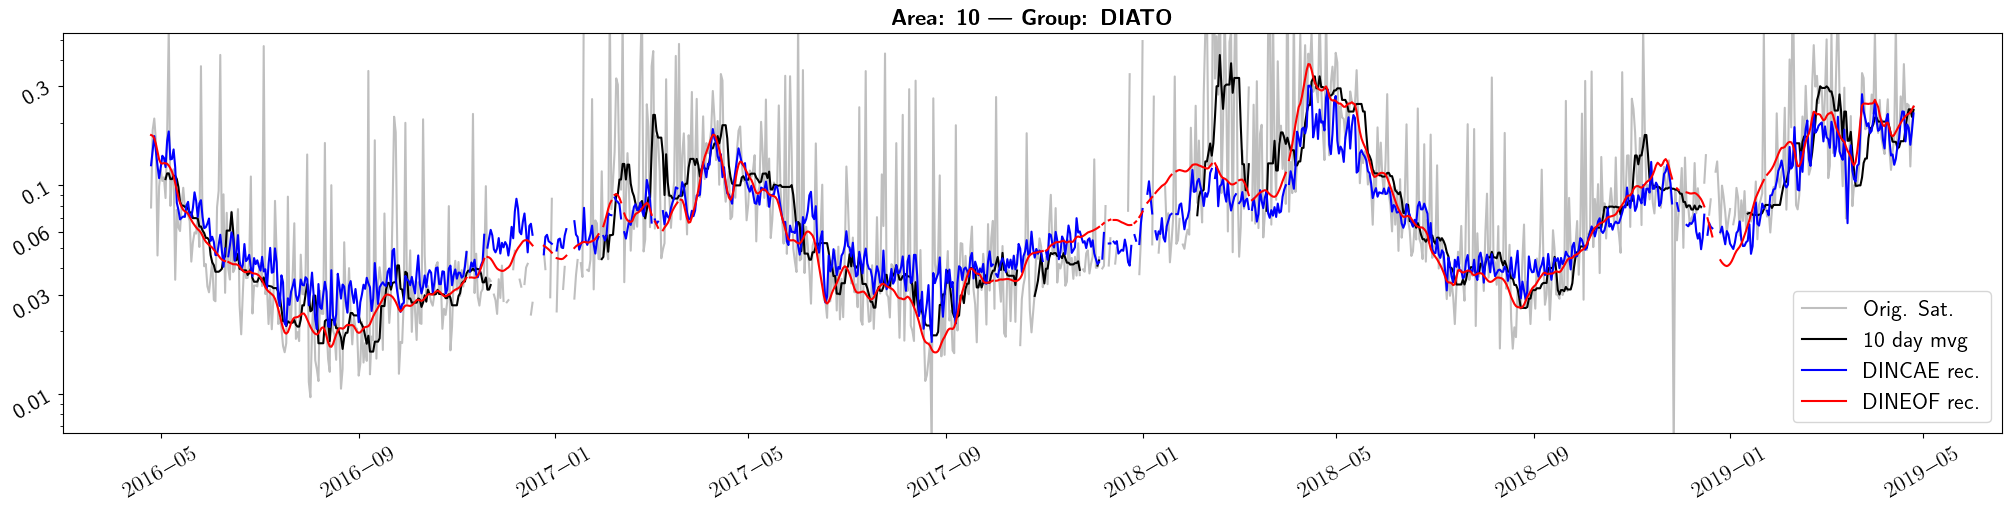

In [10]:
## Plot specific area and group
pft='DIATO'
region=10
rolling=10

fig, ax = plt.subplots(1,1, figsize=(20,5), constrained_layout=True)

vmin = test_median[pft].quantile(0.10).values
vmax = test_median[pft].quantile(0.995).values

ticks = params['plot_labels'][
    (params['plot_labels']>vmin) & 
    (params['plot_labels']<vmax)
]

ax.plot(test_median.time, test_median[pft].sel(region=region), label='Orig. Sat.',c='grey', alpha=0.5)
ax.plot(test_median.time, test_median.rolling(time=rolling).median()[pft].sel(region=region), label=f'{rolling} day mvg',c='k')

ax.plot(dincae_median.time, dincae_median[pft].sel(region=region), label='DINCAE rec.',c='blue')
ax.plot(dineof_median.time, dineof_median[pft].sel(region=region), label='DINEOF rec.',c='red')
ax.legend(fontsize=16)
ax.set_title(rf'$\textbf{{Area: {region} | Group: {pft}}}$', fontsize=16)
ax.set_yscale('log')
ax.set_yticks(ticks,[str(i) for i in ticks]);
ax.tick_params(labelsize=16, rotation=30)
ax.set_ylim(vmin, vmax);

plt.savefig(f'fig/timeserie_{pft}_area{region}.png', dpi=300, bbox_inches='tight')